Equations

$ Y_{warehouse}(t) =  Y_{warehouse}(t-1) + x_{delivered}(t) - x_{load}(t) $


$ Y_{parking}(t) =  Y_{parking}(t-1) + x_{load}(t) - x_{hoist}(t) $


$ Y_{Hoist}(t) =  Y_{Hoist}(t-1) + x_{hoist}(t) - x_{install}(t) $


$ Y_{install}(t) =  Y_{install}(t-1) + x_{install}(t) $




In [1]:
import pandas as pd 
import datetime
import numpy as np
from ortools.linear_solver import pywraplp
import matplotlib.pyplot as plt
%matplotlib inline

## Setting up the optimization

In [2]:
# Create the mip solver with the SCIP backend.
solver = pywraplp.Solver.CreateSolver('SCIP')
 
 

## Generate Random delivery Data

In [3]:
delivery=pd.DataFrame([])
delivery["date"]=pd.date_range(start='1/1/2022', end='4/30/2022')
deli=[]
for i in range(len(delivery)):
    if sum(deli) <= 44 :
        deli.append(np.random.poisson(1,1)[0])
    else :
        deli.append(0)
deli = np.array(deli)

delivery["shipment"]=deli
#delivery["shipment"]=0
#delivery["shipment"].iloc[0:89]=1

delivery["time_index"]=range(1,len(delivery)+1)
n=len(delivery)

In [4]:
delivery["date"]

0     2022-01-01
1     2022-01-02
2     2022-01-03
3     2022-01-04
4     2022-01-05
         ...    
115   2022-04-26
116   2022-04-27
117   2022-04-28
118   2022-04-29
119   2022-04-30
Name: date, Length: 120, dtype: datetime64[ns]

In [5]:
np.random.poisson(1,1)[0]

1

In [6]:
delivery.head()

,date,shipment,time_index
0,2022-01-01,3,1
1,2022-01-02,0,2
2,2022-01-03,0,3
3,2022-01-04,2,4
4,2022-01-05,0,5


## Defining Variables

$x_{delivered}(t)$     $~~~~~~~~~~~~~~~~$     PBUs delivered into the warehouse at each time frame

$Y_{warehouse}(t)$     $~~~~~~~~~~~~~~~~$     PBUs in warehouse at each time frame

$x_{load}(t)$     $~~~~~~~~~~~~~~~~$     PBUs loaded from the warehouse into the parking at each time frame

$Y_{parked}(t)$     $~~~~~~~~~~~~~~~~$     PBUs in parking at each time frame

$x_{hoist}(t)$     $~~~~~~~~~~~~~~~~$     PBUs selected from the parking, and and to be hoisted at each time frame

$Y_{hoisted}(t)$     $~~~~~~~~~~~~~~~~$     PBUs which are hoisted at each time frame

$x_{install}(t)$     $~~~~~~~~~~~~~~~~$     PBUs selected from the hoisted ones, and to be installed at each time frame

$Y_{installed}(t)$     $~~~~~~~~~~~~~~~~$     PBUs installed at each time frame



$C_{hoist}$     $~~~~~~~~~~~~~~~~$     Maximum PBUs can be hoisted at each time frame

$C_{install}$     $~~~~~~~~~~~~~~~~$     Maximum PBUs can be installed at each time frame

$C_{parked}$     $~~~~~~~~~~~~~~~~$     Maximum PBUs in parking at each time frame

$C_{load}$     $~~~~~~~~~~~~~~~~$     Maximum PBUs loaded from the warehouse into the parking at each time frame

$C_{installed}$     $~~~~~~~~~~~~~~~~$   Maximum  PBUs installed 

In [7]:
C_hoist= 10
C_install= 8
C_parked= 30
C_load=50
C_installed=44

In [8]:
Initial_Warehouse_Quantity=0

In [9]:
infinity = solver.infinity()
Y_warehouse={}

for i in range (0,n):
    Y_warehouse[i]=solver.IntVar(lb=0,ub=infinity,name="Y_warehouse_%i" % i)

In [10]:
Y_parked={}

for i in range (0,n):
    Y_parked[i]=solver.IntVar(lb=0,ub=C_parked,name="Y_parked_%i" % i)

In [11]:
x_load={}

for i in range (0,n):
    x_load[i]=solver.IntVar(lb=0,ub=C_load,name="x_load_%i" % i)

In [12]:
x_hoist={}
for i in range (0,n):
    x_hoist[i]=solver.IntVar(lb=0,ub=C_hoist,name="x_hoist_%i" % i)

In [13]:
Y_hoisted={}
for i in range (0,n):
    Y_hoisted[i]=solver.IntVar(lb=0,ub=C_hoist,name="Y_hoisted_%i" % i)

In [14]:
x_install={}
for i in range (0,n):
    x_install[i]=solver.IntVar(lb=0,ub=C_install,name="x_install_%i" % i)

In [15]:
Y_installed={}
for i in range (0,n):
    Y_installed[i]=solver.IntVar(lb=0,ub=C_installed,name="Y_installed_%i" % i)

In [16]:
print('Number of variables =', solver.NumVariables())

Number of variables = 840


## Defining Mathematical Relationship Between Variables 

The number of the PBUs in the warehouse at time $t$ = The number of the PBUs in the warehouse at time $t-1$  +  the number of PBUs delivered to warehouse at time $t$   -  the number of PBUs loaded from warehouse to parking at time $t$

$ Y_{warehouse}(t) =  Y_{warehouse}(t-1) + x_{delivered}(t) - x_{load}(t) $


In [17]:
for t in range(1,n):
    solver.Add(Y_warehouse[t] == Y_warehouse[t-1] + delivery["shipment"].values[t] - x_load[t])

The number of PBUs in parking at time $t$ = The number of PBUs in parking at time $t-1$ + The number of PBUs loaded from warehouse to parking at time $t$ - The number of PBUs selected from the parking, and to be hoisted at time $t$

$ Y_{parked}(t) =  Y_{parked}(t-1) + x_{load}(t) - x_{hoist}(t) $


In [18]:
for t in range(1,n):
    solver.Add(Y_parked[t] == Y_parked[t-1] + x_load[t] - x_hoist[t])

The number of PBUs which are hoisted at each time frame at time $t$ =  The number of PBUs which are hoisted at each time frame at time $t-1$ + The number of PBUs selected from the parking, and to be hoisted at time $t$ - The number PBUs selected from the hoisted ones, and to be installed at each time frame

$ Y_{Hoisted}(t) =  Y_{Hoisted}(t-1) + x_{hoist}(t) - x_{install}(t) $


In [19]:
for t in range(1,n):
    solver.Add(Y_hoisted[t] == Y_hoisted[t-1] + x_hoist[t] - x_install[t])

The Number of PBUs selected from the hoisted ones, and to be installed at each time frame at time $t$ = The Number of PBUs selected from the hoisted ones, and to be installed at each time frame at time $t-1$ + The number of PBUs selected from the hoisted ones, and to be installed at each time frame

$ Y_{installed}(t) =  Y_{installed}(t-1) + x_{install}(t) $


In [20]:
for t in range(1,n):
    solver.Add(Y_installed[t] == Y_installed[t-1] + x_install[t])

In [21]:
Initial_Warehouse_Quantity=0

In [22]:
solver.Add(Y_warehouse[0] == Initial_Warehouse_Quantity)

<ortools.linear_solver.pywraplp.Constraint; proxy of <Swig Object of type 'operations_research::MPConstraint *' at 0x000001E041FFEA20> >

In [23]:
print('Number of constraints =', solver.NumConstraints())

Number of constraints = 477


In [24]:
KPI_warehouse=sum(Y_warehouse[i] for i in range( 0,n))
KPI_installation= sum(Y_installed[i] for i in range( 0,n))

In [25]:
solver.Minimize(KPI_warehouse - KPI_installation )
#Y_warehouse[89]
solver.Solve()



0

In [26]:
solver.Objective().Value()

-5268.0

In [27]:
solver.OPTIMAL

0

Y_parked

In [28]:
Y_warehouse_solution=[Y_warehouse[i].solution_value() for i in range(0,n)]
x_load_solution=[x_load[i].solution_value() for i in range(0,n)]
Y_parked_solution=[Y_parked[i].solution_value() for i in range(0,n)]
x_hoist_solution=[x_hoist[i].solution_value() for i in range(0,n)]
Y_hoisted_solution=[Y_hoisted[i].solution_value() for i in range(0,n)]
x_install_solution=[x_install[i].solution_value() for i in range(0,n)]
Y_installed_solution=[Y_installed[i].solution_value() for i in range(0,n)]
 
 

In [29]:
import matplotlib.dates as mdates


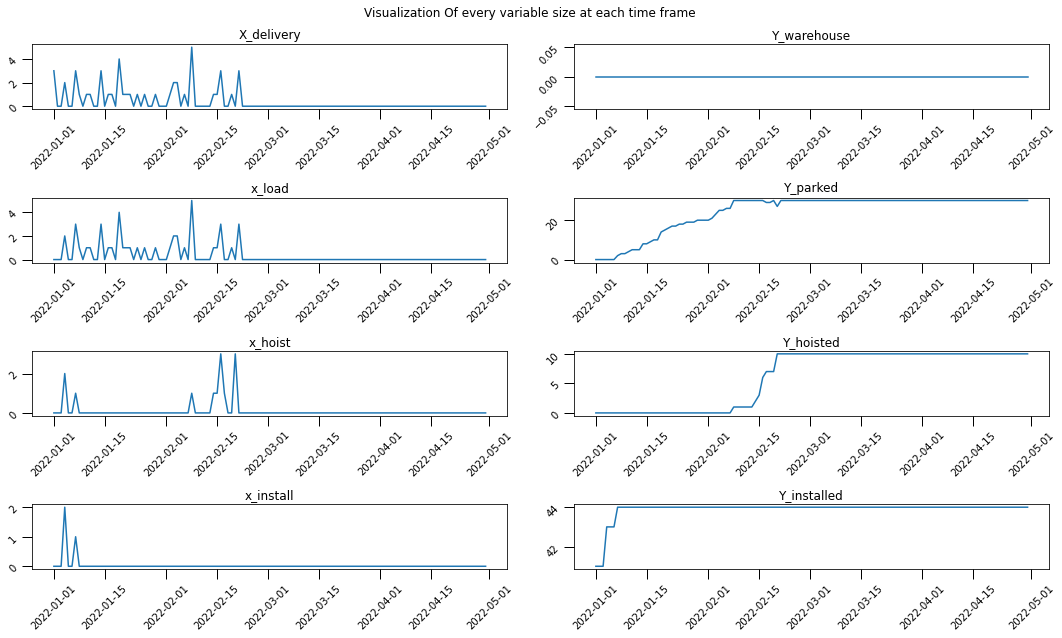

In [30]:
fig, ax = plt.subplots(4, 2 ,figsize= (15,9) )
 
ax[0,0].plot(delivery["date"],delivery["shipment"].values)
ax[0, 0].set_title("X_delivery")
ax[0, 0].tick_params(direction='out', length=10, width=1,labelrotation=45)
 
  
ax[0,1].plot(delivery["date"],Y_warehouse_solution)
ax[0, 1].set_title("Y_warehouse")
ax[0, 1].tick_params(direction='out', length=10, width=1,labelrotation=45)

ax[1,0].plot(delivery["date"],x_load_solution)
ax[1,0].set_title("x_load")
ax[1,0].tick_params(direction='out', length=10, width=1,labelrotation=45)

ax[1,1].plot(delivery["date"],Y_parked_solution)
ax[1, 1].set_title("Y_parked")
ax[1, 1].tick_params(direction='out', length=10, width=1,labelrotation=45)

ax[2,0].plot(delivery["date"],x_hoist_solution)
ax[2, 0].set_title("x_hoist")
ax[2, 0].tick_params(direction='out', length=10, width=1,labelrotation=45)

ax[2,1].plot(delivery["date"],Y_hoisted_solution)
ax[2, 1].set_title("Y_hoisted")
ax[2, 1].tick_params(direction='out', length=10, width=1,labelrotation=45)

ax[3,0].plot(delivery["date"],x_install_solution)
ax[3, 0].set_title("x_install")
ax[3, 0].tick_params(direction='out', length=10, width=1,labelrotation=45)

ax[3,1].plot(delivery["date"],Y_installed_solution)
ax[3, 1].set_title("Y_installed")
ax[3, 1].tick_params(direction='out', length=10, width=1,labelrotation=45)

fig.suptitle("Visualization Of every variable size at each time frame")
fig.tight_layout()

 